##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TensorFlow 2 quickstart for beginners

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/quickstart/beginner"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/quickstart/beginner.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This short introduction uses [Keras](https://www.tensorflow.org/guide/keras/overview) to:

1. Build a neural network that classifies images.
2. Train this neural network.
3. And, finally, evaluate the accuracy of the model.

This is a [Google Colaboratory](https://colab.research.google.com/notebooks/welcome.ipynb) notebook file. Python programs are run directly in the browser—a great way to learn and use TensorFlow. To follow this tutorial, run the notebook in Google Colab by clicking the button at the top of this page.

1. In Colab, connect to a Python runtime: At the top-right of the menu bar, select *CONNECT*.
2. Run all the notebook code cells: Select *Runtime* > *Run all*.

Download and install TensorFlow 2. Import TensorFlow into your program:

Note: Upgrade `pip` to install the TensorFlow 2 package. See the [install guide](https://www.tensorflow.org/install) for details.

In [2]:
import tensorflow as tf

In [3]:
# Defining a callback function coutesy of Justin
# Doing this before everything else so that it doesn't interfere with other code.
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.accuracies = []
    def on_train_batch_begin(self, batch, logs={}):
        pass
    def on_train_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accuracies.append(logs.get('accuracy'))

In [4]:
# Initializing

history = LossHistory()

Load and prepare the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). Convert the samples from integers to floating-point numbers:

In [5]:
mnist = tf.keras.datasets.mnist

# Typical train/test splitting
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

Build the `tf.keras.Sequential` model by stacking layers. Choose an optimizer and loss function for training:

In [6]:
# We are using a sequential model
model = tf.keras.models.Sequential([      
  tf.keras.layers.Flatten(input_shape=(28, 28)),  # Make data 1D for neuron input
  tf.keras.layers.Dense(128, activation='relu'),  # Dense layer that will use relu (nonlinear) activation and output 128 units
  tf.keras.layers.Dropout(0.2), # Layer that will andomize 20% of data
  tf.keras.layers.Dense(10) # Another dense layer will output 10 units 
])

For each example the model returns a vector of "[logits](https://developers.google.com/machine-learning/glossary#logits)" or "[log-odds](https://developers.google.com/machine-learning/glossary#log-odds)" scores, one for each class.

In [7]:
predictions = model(x_train[:1]).numpy() 
predictions # non-normalized prediction values (makes a lot more sense after normalizing)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



array([[-0.10225835, -0.28545672, -0.68875   ,  0.33214808, -0.3466305 ,
        -0.09302476, -0.3378637 , -0.3068619 ,  0.63623524,  0.5277976 ]],
      dtype=float32)

The `tf.nn.softmax` function converts these logits to "probabilities" for each class: 

In [8]:
tf.nn.softmax(predictions).numpy() # Softmax normalization - normalization in this case is not the typical statistical normalization

array([[0.08848809, 0.07367545, 0.04922375, 0.1366297 , 0.06930352,
        0.08930893, 0.06991376, 0.07211518, 0.18518615, 0.16615546]],
      dtype=float32)

Note: It is possible to bake this `tf.nn.softmax` in as the activation function for the last layer of the network. While this can make the model output more directly interpretable, this approach is discouraged as it's impossible to
provide an exact and numerically stable loss calculation for all models when using a softmax output. 

The `losses.SparseCategoricalCrossentropy` loss takes a vector of logits and a `True` index and returns a scalar loss for each example.

In [9]:
# Using crossentropy to compare the probabilities of the dataset
# to the probabilities of the model
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

This loss is equal to the negative log probability of the true class:
It is zero if the model is sure of the correct class.

This untrained model gives probabilities close to random (1/10 for each class), so the initial loss should be close to `-tf.log(1/10) ~= 2.3`.

In [10]:
# Calculate the loss of our predictions on the training set - 
# ultimately this doesn't give us much information
loss_fn(y_train[:1], predictions).numpy()

2.4156537

In [11]:
# Adam is an implementation of gradient descent
# The metric we care about is accuracy.
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

The `Model.fit` method adjusts the model parameters to minimize the loss: 

In [12]:
# The model is defined and the components constructed,
# now we fit the model over 5 epochs (data distributed into 5 subsets).
model.fit(x_train, y_train, epochs=5, callbacks=[history])

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 4s 63us/sample - loss: 0.2968 - accuracy: 0.9138
Epoch 2/5
60000/60000 [==============================] - 4s 61us/sample - loss: 0.1443 - accuracy: 0.9574
Epoch 3/5
60000/60000 [==============================] - 4s 61us/sample - loss: 0.1074 - accuracy: 0.9678
Epoch 4/5
60000/60000 [==============================] - 4s 60us/sample - loss: 0.0898 - accuracy: 0.9719
Epoch 5/5
60000/60000 [==============================] - 4s 61us/sample - loss: 0.0783 - accuracy: 0.9755


The `Model.evaluate` method checks the models performance, usually on a "[Validation-set](https://developers.google.com/machine-learning/glossary#validation-set)" or "[Test-set](https://developers.google.com/machine-learning/glossary#test-set)".

In [13]:
# Evaluate for accuracy against a validation set
model.evaluate(x_test,  y_test, verbose=2)

10000/1 - 0s - loss: 0.0383 - accuracy: 0.9768


[0.07388509614518844, 0.9768]

The image classifier is now trained to ~98% accuracy on this dataset. To learn more, read the [TensorFlow tutorials](https://www.tensorflow.org/tutorials/).

If you want your model to return a probability, you can wrap the trained model, and attach the softmax to it:

In [14]:
# Doing what they told us not to do in a separate model.
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

In [15]:
probability_model(x_test[:5])

<tf.Tensor: id=30017, shape=(5, 10), dtype=float32, numpy=
array([[6.5786299e-10, 1.6011008e-09, 1.8996509e-05, 2.9291959e-05,
        1.7354188e-12, 1.6257015e-08, 3.5795943e-16, 9.9995100e-01,
        5.3467215e-08, 6.8582096e-07],
       [4.2513967e-08, 7.1939103e-05, 9.9990976e-01, 1.4445771e-05,
        1.5207478e-15, 1.4768309e-06, 8.2264046e-07, 9.5448616e-13,
        1.5983065e-06, 8.5231784e-15],
       [3.6208687e-06, 9.9783236e-01, 2.4182096e-04, 3.8506125e-05,
        2.2618347e-05, 1.0231521e-05, 2.8649943e-05, 1.6256102e-03,
        1.9610862e-04, 5.3863357e-07],
       [9.9997091e-01, 9.8443698e-10, 1.8830979e-05, 8.5710683e-09,
        2.2463097e-07, 2.6432165e-06, 8.7526718e-07, 3.2739254e-06,
        3.8229768e-08, 3.1385530e-06],
       [6.8379127e-06, 3.0120617e-08, 1.6601214e-05, 3.3790354e-08,
        9.9233365e-01, 2.2791507e-08, 1.9790866e-06, 2.4948367e-05,
        1.2959450e-06, 7.6145246e-03]], dtype=float32)>

In [16]:
# Now let's plot some data.
# Just important some MPL libraries
from matplotlib import pyplot as plt


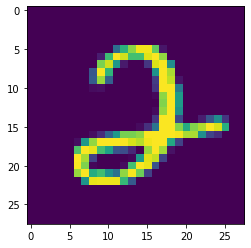

In [17]:
# Show the 16th number of the training set
numplot = plt.imshow(x_train[16])

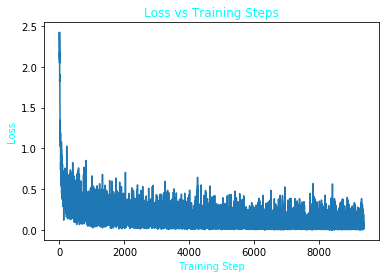

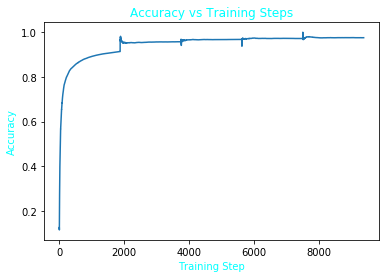

In [18]:
# Plotting loss and accuracy
loss_y = history.losses
#x = [i for i in range(0, x_train.size)]
plt.title("Loss vs Training Steps", color='cyan')
plt.xlabel("Training Step", color='cyan')
plt.ylabel('Loss', color='cyan')
plt.plot(loss_y)

acc_y = history.accuracies
plt.figure()
plt.title("Accuracy vs Training Steps", color='cyan')
plt.xlabel("Training Step", color='cyan')
plt.ylabel('Accuracy', color='cyan')
plt.plot(acc_y)
